# Imports

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay



# Get the dataFrame

In [9]:
df = pd.read_csv('data/weblogs_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67152 entries, 0 to 67151
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  67152 non-null  object 
 1   NUMBER_OF_REQUESTS  67152 non-null  int64  
 2   TOTAL_DURATION      67152 non-null  int64  
 3   AVERAGE_TIME        67152 non-null  float64
 4   STANDARD_DEVIATION  52816 non-null  float64
 5   REPEATED_REQUESTS   67152 non-null  float64
 6   HTTP_RESPONSE_2XX   67152 non-null  float64
 7   HTTP_RESPONSE_3XX   67152 non-null  float64
 8   HTTP_RESPONSE_4XX   67152 non-null  float64
 9   HTTP_RESPONSE_5XX   67152 non-null  float64
 10  GET_METHOD          67152 non-null  float64
 11  POST_METHOD         67152 non-null  float64
 12  HEAD_METHOD         67152 non-null  float64
 13  OTHER_METHOD        67152 non-null  float64
 14  NIGHT               67152 non-null  float64
 15  UNASSIGNED          67152 non-null  float64
 16  IMAG

## Analyze & Visualize the data

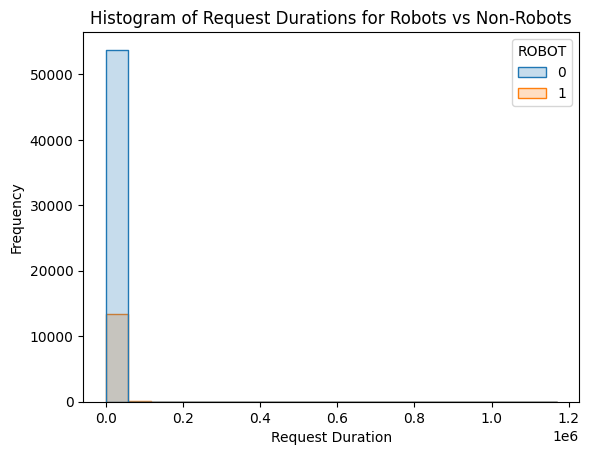

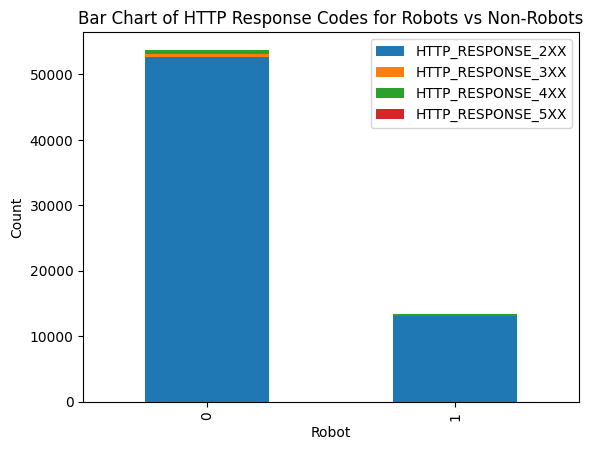

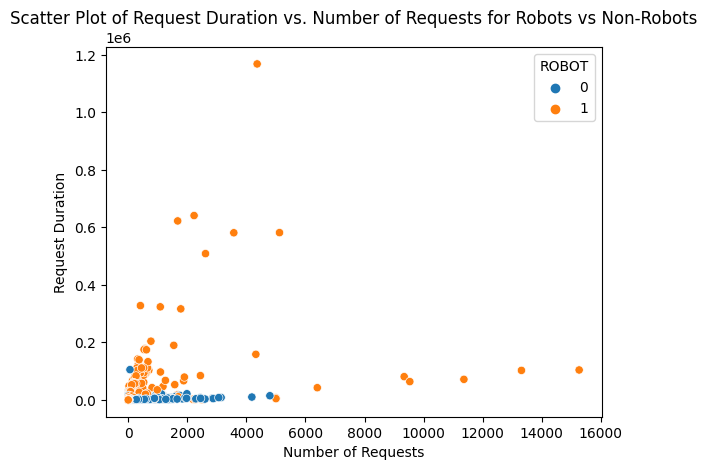

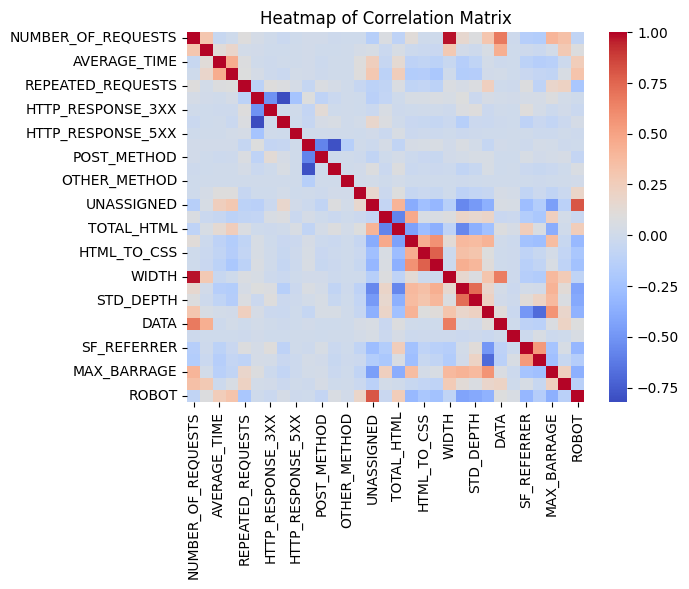

In [10]:
# Plot a histogram of request durations for robots vs non-robots
sns.histplot(df, x="TOTAL_DURATION", hue="ROBOT", element="step", bins=20)
plt.xlabel("Request Duration")
plt.ylabel("Frequency")
plt.title("Histogram of Request Durations for Robots vs Non-Robots")
plt.show()

# Create a bar chart of HTTP response codes for robots vs non-robots
counts = df.groupby("ROBOT")[["HTTP_RESPONSE_2XX", "HTTP_RESPONSE_3XX", "HTTP_RESPONSE_4XX", "HTTP_RESPONSE_5XX"]].sum()
counts.plot(kind="bar", stacked=True)
plt.xlabel("Robot")
plt.ylabel("Count")
plt.title("Bar Chart of HTTP Response Codes for Robots vs Non-Robots")
plt.show()

# Plot a scatter plot of request duration vs. number of requests for robots vs non-robots
sns.scatterplot(x="NUMBER_OF_REQUESTS", y="TOTAL_DURATION", hue="ROBOT", data=df)
plt.xlabel("Number of Requests")
plt.ylabel("Request Duration")
plt.title("Scatter Plot of Request Duration vs. Number of Requests for Robots vs Non-Robots")
plt.show()

corr = df.corr(numeric_only=True)
# Plot the heatmap
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Heatmap of Correlation Matrix")
plt.show()

# Frame the problem

- Classes: 2, 0 = human, 1 = robot
- Model has to be binary & able to handle a lot of features
- Model has to be a classifier
- Choices:
    - Mini-batch Gradient Descent
    - Logistic Regression
    - Support Vector Machine
    - Random Forest
    - Decision Tree
    - Neural Network

# Create a test set & a training set

In [11]:
# Drop the ID column
df = df.drop(columns=["ID"])
# df.dropna(inplace=True)
# Split the data into training and test sets
X = df.drop(columns=["ROBOT"])
y = df["ROBOT"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((47534, 30), (5282, 30), (47534,), (5282,))

# Create a pipeline

In [5]:
imputers = [
    ("median_imputer", SimpleImputer(strategy="median")),
    ("most_frequent_imputer", SimpleImputer(strategy="most_frequent")),
    ("constant_imputer_0", SimpleImputer(strategy="constant", fill_value=0)),
    ("constant_imputer_-1", SimpleImputer(strategy="constant", fill_value=-1)),
    ("mean_imputer", SimpleImputer(strategy="mean")),
    ("knn_imputer_5", KNNImputer(n_neighbors=5)),
    ("knn_imputer_10", KNNImputer(n_neighbors=10)),
]

scalers = [
    ("standard_scaler", StandardScaler()),
    ("minmax_scaler", MinMaxScaler()),
    ("maxabs_scaler", MaxAbsScaler()),
    ("robust_scaler", RobustScaler())
]

models = [
    ("mini_batch_gradient_descent", SGDClassifier()),
    ("logistic_regression", LogisticRegression(max_iter=500)),
    ("support_vector_machine", SVC()),
    ("random_forest", RandomForestClassifier()),
    ("decision_tree", DecisionTreeClassifier()),
]

pipelineResults = []
amount = len(imputers) * len(scalers) * len(models)

for imputer in imputers:
    X_train_imputed = imputer[1].fit_transform(X_train)
    X_test_imputed = imputer[1].transform(X_test)
    for scaler in scalers:
        X_train_scaled = scaler[1].fit_transform(X_train_imputed)
        X_test_scaled = scaler[1].transform(X_test_imputed)
        for model in models:

            print(f"Training... {len(pipelineResults)}/{amount}" + " " * 20, end="\r")
            # Fit the pipeline
            model[1].fit(X_train_scaled, y_train)

            # Get the training and test accuracy
            train_acc = model[1].score(X_train_scaled, y_train)
            test_acc = model[1].score(X_test_scaled, y_test)

            # Add the results to the dataframe
            pipelineResults.append(
                {
                    "Imputer": imputer[0],
                    "Scaler": scaler[0],
                    "Model": model[0],
                    "Training Accuracy": train_acc,
                    "Test Accuracy": test_acc
                }
            )

pipelineResults = pd.DataFrame(pipelineResults)
pipelineResults

,Imputer,Scaler,Model,Training Accuracy,Test Accuracy
0,median_imputer,standard_scaler,mini_batch_gradient_descent,0.945529,0.944163
1,median_imputer,standard_scaler,logistic_regression,0.946009,0.943716
2,median_imputer,standard_scaler,support_vector_machine,0.962771,0.958160
3,median_imputer,standard_scaler,random_forest,0.985456,0.975581
4,median_imputer,standard_scaler,decision_tree,0.992653,0.975134
...,...,...,...,...,...
135,knn_imputer_10,robust_scaler,mini_batch_gradient_descent,0.468280,0.468731
136,knn_imputer_10,robust_scaler,logistic_regression,0.562612,0.562835
137,knn_imputer_10,robust_scaler,support_vector_machine,0.802336,0.791543
138,knn_imputer_10,robust_scaler,random_forest,0.993994,0.980941


In [6]:
pipelineResults.sort_values(by="Test Accuracy", ascending=False, inplace=True)
pipelineResults

,Imputer,Scaler,Model,Training Accuracy,Test Accuracy
138,knn_imputer_10,robust_scaler,random_forest,0.993994,0.980941
38,most_frequent_imputer,robust_scaler,random_forest,0.993977,0.979899
58,constant_imputer_0,robust_scaler,random_forest,0.993977,0.979899
123,knn_imputer_10,standard_scaler,random_forest,0.992124,0.979750
78,constant_imputer_-1,robust_scaler,random_forest,0.993977,0.979601
...,...,...,...,...,...
96,mean_imputer,robust_scaler,logistic_regression,0.562562,0.562835
76,constant_imputer_-1,robust_scaler,logistic_regression,0.562628,0.562835
136,knn_imputer_10,robust_scaler,logistic_regression,0.562612,0.562835
36,most_frequent_imputer,robust_scaler,logistic_regression,0.562612,0.562835


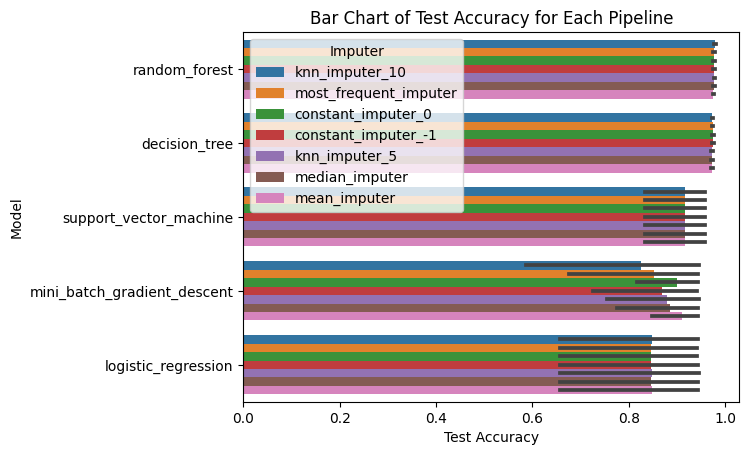

In [7]:
# Create a bar chart of the test accuracy for each pipeline
sns.barplot(x="Test Accuracy", y="Model", hue="Imputer", data=pipelineResults)
plt.xlabel("Test Accuracy")
plt.ylabel("Model")
plt.title("Bar Chart of Test Accuracy for Each Pipeline")
plt.show()

# Fine-tune the best model

In [10]:
best_pipeline = [
    ("imputer", KNNImputer(n_neighbors=10)),
    ("scaler", RobustScaler()),
    ("model", RandomForestClassifier())
]

# Create a grid of hyperparameters
param_grid = {
    "n_estimators": [1, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [1, 10, 20],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "class_weight": ["balanced", "balanced_subsample", None],
}

limit = 50

grid_steps = {
    "n_estimators": int((param_grid["n_estimators"][2] - param_grid["n_estimators"][1]) / limit),
    "max_depth": int((param_grid["max_depth"][2] - param_grid["max_depth"][1]) / limit),
    "min_samples_split": int((param_grid["min_samples_split"][2] - param_grid["min_samples_split"][1]) / limit),
    "min_samples_leaf": int((param_grid["min_samples_leaf"][2] - param_grid["min_samples_leaf"][1]) / limit),
}

for key in grid_steps:
    if grid_steps[key] < 1:
        grid_steps[key] = 1

best_params = {
    "n_estimators": None,
    "max_depth": None,
    "min_samples_split": None,
    "min_samples_leaf": None,
    "max_features": None,
    "bootstrap": None,
    "criterion": None,
    "class_weight": None
}


# Create the grid search
# Perform a big grid search 

# Process the data 
X_train_scaled = best_pipeline[1][1].fit_transform(best_pipeline[0][1].fit_transform(X_train))
X_test_scaled = best_pipeline[1][1].transform(best_pipeline[0][1].transform(X_test))

for i in range(limit):
    print(f"Grid search {i+1}/{limit}" + " " * 20)
    grid_search = GridSearchCV(best_pipeline[2][1], param_grid, verbose=0, n_jobs=-1, scoring=["accuracy", "f1"], refit=False)
    # Fit the grid search
    grid_search.fit(X_train_scaled, y_train)

    # Get the best parameters
    new_params = {
        "n_estimators": grid_search.best_params_["n_estimators"],
        "max_depth": grid_search.best_params_["max_depth"],
        "min_samples_split": grid_search.best_params_["min_samples_split"],
        "min_samples_leaf": grid_search.best_params_["min_samples_leaf"],
        "max_features": grid_search.best_params_["max_features"],
        "bootstrap": grid_search.best_params_["bootstrap"],
        "criterion": grid_search.best_params_["criterion"],
        "class_weight": grid_search.best_params_["class_weight"],
        "accuracy": grid_search.best_score_
    }

    # Compare the new params to the old params
    if all([best_params[key] == new_params[key] for key in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "max_features", "bootstrap", "criterion", "class_weight"]]):
        # If the parameters haven't changed, break out of the loop
        print("The grid search has converged.")
        break

    best_params = new_params
    # Change the param_grid
    param_grid = {
        "n_estimators": [
            best_params["n_estimators"] - grid_steps["n_estimators"] if best_params["n_estimators"] > 1 else 1, 
            best_params["n_estimators"], 
            best_params["n_estimators"] + grid_steps["n_estimators"]
        ],
        "max_depth": [
            best_params["max_depth"] - grid_steps["max_depth"] if best_params["max_depth"] is not None else None, 
            best_params["max_depth"], 
            best_params["max_depth"] + grid_steps["max_depth"] if best_params["max_depth"] is not None else grid_steps["max_depth"]
        ],
        "min_samples_split": [
            best_params["min_samples_split"] - grid_steps["min_samples_split"] if best_params["min_samples_split"] > 1 else 1, 
            best_params["min_samples_split"], 
            best_params["min_samples_split"] + grid_steps["min_samples_split"]
        ],
        "min_samples_leaf": [
            best_params["min_samples_leaf"] - grid_steps["min_samples_leaf"] if best_params["min_samples_leaf"] > 1 else 1, 
            best_params["min_samples_leaf"], 
            best_params["min_samples_leaf"] + grid_steps["min_samples_leaf"]
        ],
        "max_features": ["auto", "sqrt", "log2"],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"],
        "class_weight": ["balanced", "balanced_subsample", None],
    
    }

best_params

Grid search 1/10                    
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Grid search 2/10                    
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Grid search 3/10                    
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Grid search 4/10                    
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Grid search 5/10                    
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Grid search 6/10                    
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Grid search 7/10                    
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Grid search 8/10                    
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Grid search 9/10                    
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Grid search 10/10                    
Fitting 5 folds for each of 81 candidates, totalling 405 fits


# Evaluate the system on the test set

In [12]:
# Train based on the best parameters
best_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=10)),
    ("scaler", RobustScaler()),
    ("model", RandomForestClassifier(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"]
    ))
])
best_pipeline.fit(X_train, y_train)

# Get the training and test accuracy
train_acc = best_pipeline.score(X_train, y_train)
test_acc = best_pipeline.score(X_test, y_test)

print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

# Get the predictions

predictions = best_pipeline.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

# Plot the confusion matrix with percentage values
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_test, predictions,
                                        normalize="true", values_format=".6%", cmap="PuBu")


NameError: name 'best_params' is not defined